# Computing a connectome

First load the useful modules for this project.

In [1]:
import os
import json
from math import prod
import matplotlib.pyplot as plt
import nibabel as nib # Load Nifti files
from nilearn import datasets, plotting, image, interfaces
from nilearn.plotting import plot_connectome
from nilearn.maskers import NiftiMasker, NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import pandas as pd

## Loading the data

The fMRI data for the subject is arranged in the same way as a Nilearn dataset to handle it more easily and re-use the tools learned in the modules.

In [2]:
data_dir = "../data/preprocess"
original_ds_dir = os.path.join(data_dir, "input")
preprocessed_ds_dir = os.path.join(data_dir, "output")

sub_ids_list = [9001]
ses_ids_list = [1, 2]
# Sl_cond: "Sleep randomisation condition. 
# 1 = sleep deprivation before first session, 
# 2 = sleep deprivation before second session"
# sub-9001 is in condition 2

data = {"func":[],
        "mask":[],
        "confounds":[],
        "phenotypic":""}

# data["func"] contains the paths to the Nifti files (the files containing fMRI data)

task = "rest"
for sub_id in sub_ids_list:
    for ses_id in ses_ids_list:
        rel_path = f"sub-{sub_id}/ses-{ses_id}/func/sub-{sub_id}_ses-{ses_id}_task-{task}_"
        
        func_path = os.path.join(preprocessed_ds_dir, rel_path)
        name = "space-MNI152NLin2009cAsym_desc-"
        data["func"].append(func_path + name + "preproc_bold.nii.gz")
        data["mask"].append(func_path + name + "brain_mask.nii.gz")
        data["confounds"].append(func_path + "desc-confounds_timeseries.tsv")

# TODO: Automatize this by searching in the 'participants.tsv' file
data["sleep"] = ["normal", "deprived"]
        
# Opening JSON file
with open(os.path.join(original_ds_dir, "dataset_description.json")) as file:
    data["description"] = json.load(file)

In [3]:
# Read the dataset documentation
for key in data["description"]:
    print(key+":")
    print(data["description"][key], "\n")

Name:
The Stockholm Sleepy Brain Study: Effects of Sleep Deprivation on Cognitive and Emotional Processing in Young and Old 

BIDSVersion:
1.0.2 

License:
CC0 

Authors:
['Gustav Nilsonne', 'Sandra Tamm', 'Paolo d’Onofrio', 'Hanna Å Thuné', 'Johanna Schwarz', 'Catharina Lavebratt', 'Jia Jia Liu', 'Kristoffer NT Månsson', 'Tina Sundelin', 'John Axelsson', 'Peter Fransson', 'Göran Kecklund', 'Håkan Fischer', 'Mats Lekander', 'Torbjörn Åkerstedt'] 

Acknowledgements:
We are grateful to Diana Cortes and Roberta Nagai for assistance with polysomnography recordings, to Birgitta Mannerstedt Fogelfors for assistance with screening, instructions to participants, and blood sampling, to Rouslan Sitnikov and Jonathan Berrebi for assistance with MRI sequences and auxiliary equipment, to Hannes Ingre for entering sleep diary data into a spreadsheet, and to William Triplett, data curator at openfmri.org, for assistance with data archiving. 

HowToAcknowledge:
We encourage researchers to use the publ

# Run for the two sessions

In [4]:
def load_img(ses_id):
    i = ses_id-1
    print("session id:", ses_id)
    print("sleep:", data["sleep"][i])
    # Load the functional image
    fmri_filepath = data['func'][i]
    mask_filepath = data["mask"][i]
    fmri_img = nib.load(fmri_filepath)
    print(fmri_img)
    return(fmri_filepath, mask_filepath, fmri_img)

**Masking the data**

Use a masker to remove the empty background voxels and regress out the confounds.

In [5]:
def mask_data(ses_id, fmri_data, fmri_filepath, mask_filepath):
    i = ses_id-1
    
    print("Number of voxels")
    print("Before masking:", prod(fmri_data[:,:,:,0].shape))
    
    # Checkout the confounds of the data
#     confounds = pd.read_csv(data["confounds"][i], sep='\t')
#     # Remove columns to avoid 'ValueError: array must not contain infs or NaNs'
#     confounds = confounds.replace([-np.inf, np.inf], np.nan).dropna(axis=1)
    confounds, sample_mask = interfaces.fmriprep.load_confounds(fmri_filepath)

    # Mask the data
    masker = NiftiMasker(mask_img=mask_filepath)
    masked_data = masker.fit_transform(fmri_filepath, sample_mask=sample_mask)#confounds=confounds)
    print("After masking:", masked_data.shape)

    thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

    thresholded_img = masker.inverse_transform(thresholded_masked_data)

    plt.imshow(thresholded_img.get_fdata()[:,:,30,0], cmap='gray')
    plt.show()
    return(confounds, thresholded_img)

**Using an atlas**

Use an atlas that defines region of interest (ROIs) to cluster the voxels to reduce the size of the connectome to compute and analyze.

In [6]:
# Using an atlas
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

**Connectome**

Compute and plot a correlation matrix.

In [7]:
def show_results(atlas_filepath, labels, fmri_filepath, confounds):
    
    atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)
    
    data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds)

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

    # Plot the correlation matrix
    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # The matrix is not reordered for block-like representation 
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8) # reorder=True)

    coords = atlas_dataset.region_coords

    # Threshold to keep only the 10% of edges with the highest value
    # because the graph is very dense
    plot_connectome(correlation_matrix, coords,
                    edge_threshold="90%", colorbar=True)

    # Threshold to keep only the 5% of edges with the highest value
    # because the graph is very dense
    plot_connectome(correlation_matrix, coords,
                    edge_threshold="95%", colorbar=True)
    
    return(correlation_matrix)

## Session 1: Normal sleep

In [8]:
fmri_filepath_1, mask_filepath_1, fmri_img_1 = load_img(ses_id=1)

session id: 1
sleep: normal
<class 'nibabel.nifti1.Nifti1Image'>
data shape (87, 103, 65, 193)
affine: 
[[   2.25    0.      0.    -96.5 ]
 [   0.      2.25    0.   -132.5 ]
 [   0.      0.      3.    -78.5 ]
 [   0.      0.      0.      1.  ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  87 103  65 193   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   2.25 2.25 3.   2.5  1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 8982.004
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip

The data is a 4D array. The last dimension is the time, so we have 193 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 2.5s, so we have a file that represents 482.5s of scanning.

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



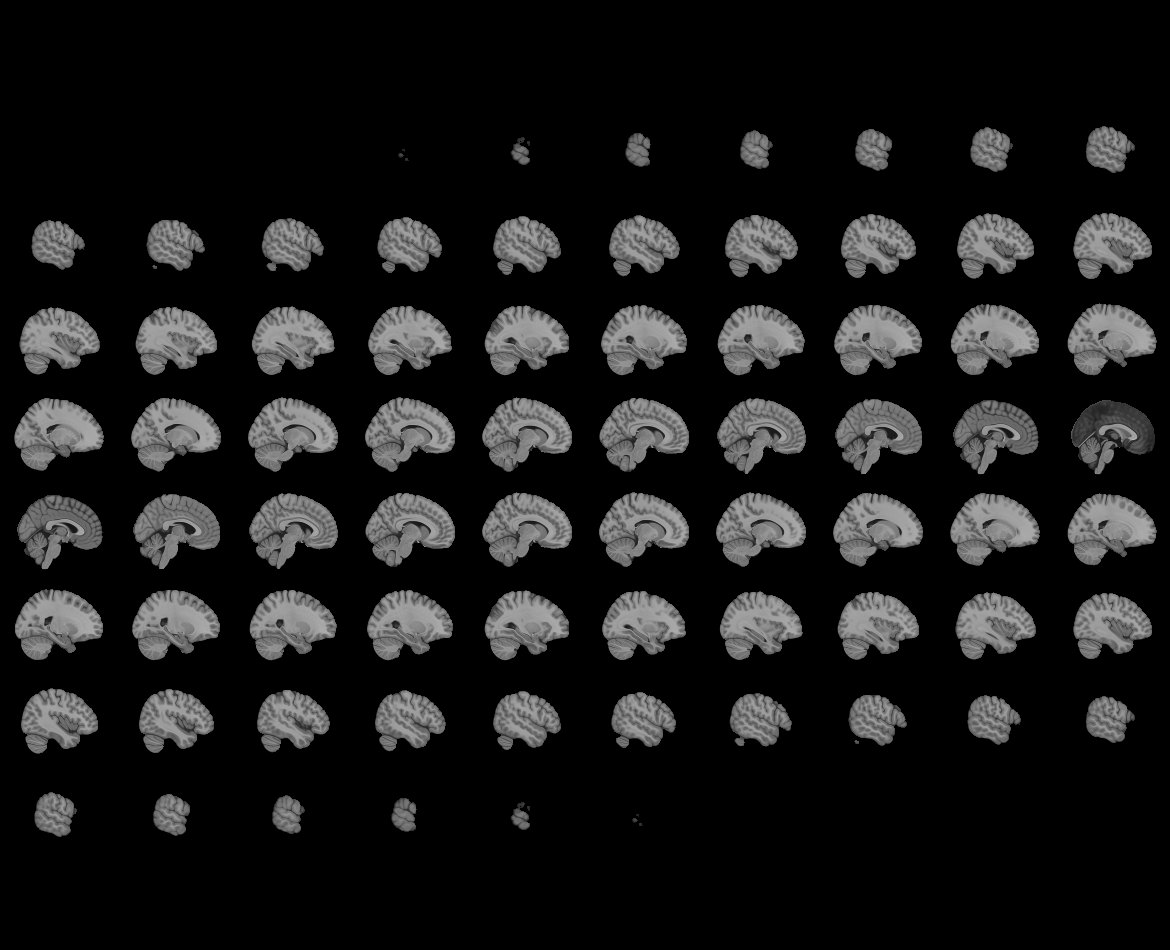
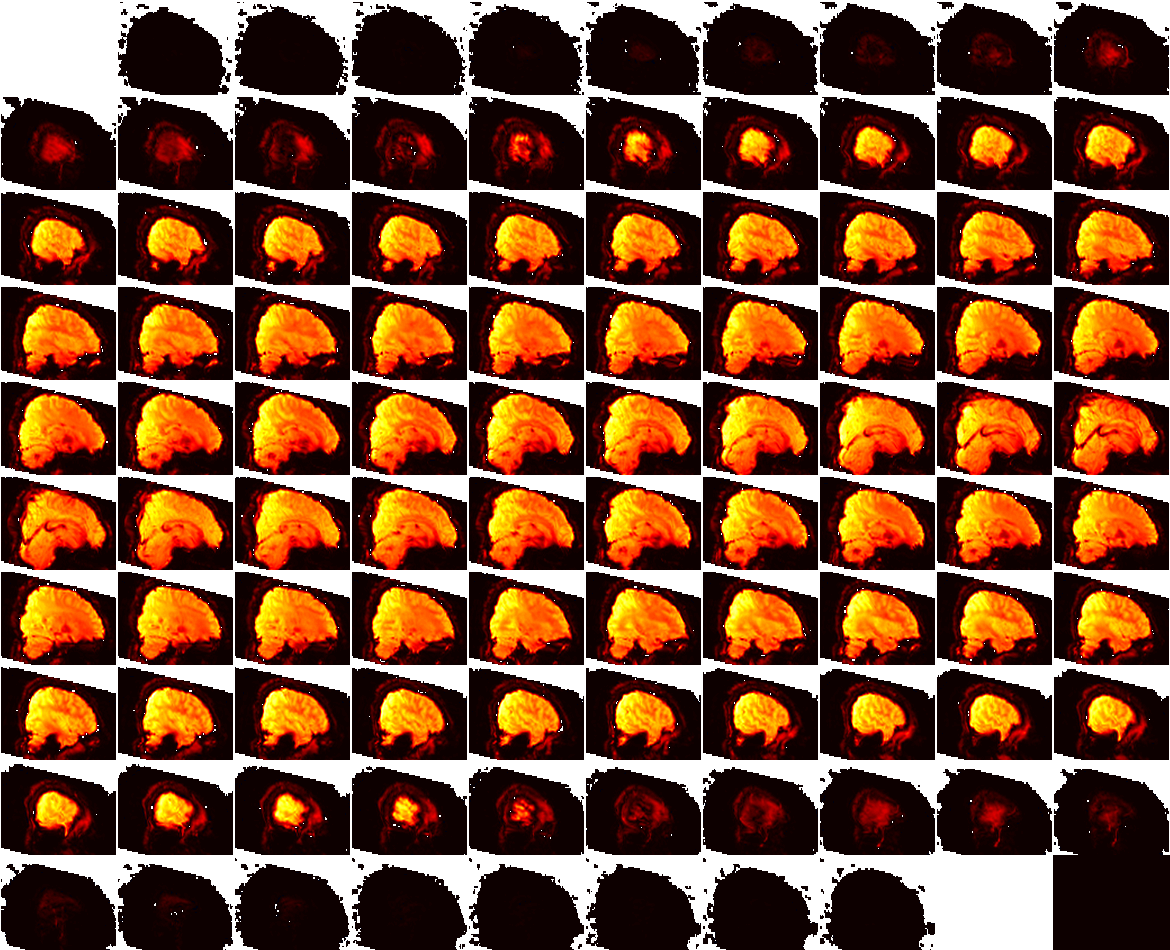

In [9]:
# Take a look at the average
plotting.view_img(image.mean_img(fmri_img_1))

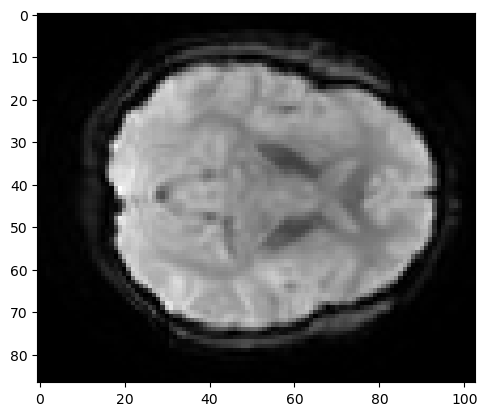

In [10]:
# let's get the data array 
fmri_data_1 = fmri_img_1.get_fdata()
# Plot a (trasnversal) slice of the brain for a time point as an image
plt.imshow(fmri_data_1[:,:,25,0], cmap='gray')

Number of voxels
Before masking: 582465
After masking: (193, 121367)


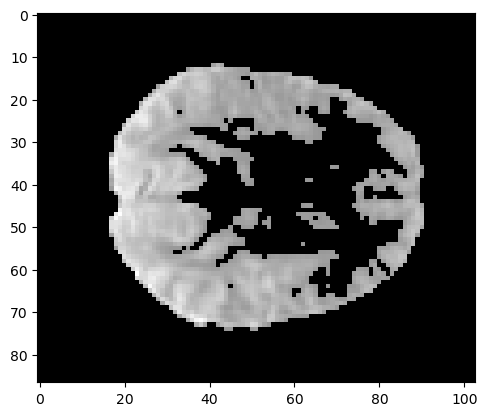

In [11]:
confounds_1, thresholded_img_1 = mask_data(1, fmri_data_1, fmri_filepath_1, mask_filepath_1)

In [12]:
confounds_1.head()

cosine00  cosine01  cosine02  cosine03  cosine04  cosine05        csf  \
0  0.101794  0.101784  0.101767  0.101743  0.101713  0.101676  24.296340   
1  0.101767  0.101676  0.101524  0.101312  0.101040  0.100707   6.307049   
2  0.101713  0.101460  0.101040  0.100452  0.099697  0.098778  26.790061   
3  0.101632  0.101137  0.100314  0.099165  0.097695  0.095908  27.568941   
4  0.101524  0.100707  0.099349  0.097459  0.095046  0.092123  16.370703   

      rot_x  rot_x_derivative1  rot_x_derivative1_power2  ...  trans_x_power2  \
0 -0.000317           0.000091             -4.404364e-08  ...        0.000846   
1 -0.000218           0.000091             -4.404364e-08  ...        0.000297   
2  0.000122           0.000332              6.177762e-08  ...       -0.000003   
3 -0.000032          -0.000161             -3.020620e-08  ...       -0.000763   
4  0.000001           0.000026             -5.263295e-08  ...       -0.000430   

    trans_y  trans_y_derivative1  trans_y_derivative1_power2  trans_y_power2  \
0 -0.077004             0.015443                    0.000158       -0.007917   
1 -0.060723             0.015443                    0.000158       -0.007656   
2 -0.038839             0.021045                    0.000371       -0.006470   
3 -0.048478            -0.010478                   -0.000015       -0.007110   
4 -0.039922             0.007717                   -0.000034       -0.006551   

    trans_z  trans_z_derivative1  trans_z_derivative1_power2  trans_z_power2  \
0 -0.096495             0.004080                   -0.000330        0.015388   
1 -0.092152             0.004080                   -0.000330        0.014239   
2 -0.101716            -0.009827                   -0.000257        0.016820   
3 -0.084646             0.016807                   -0.000057        0.012342   
4 -0.084091             0.000292                   -0.000348        0.012206   

   white_matter  
0     17.238756  
1     13.986504  
2     17.944863  
3     23.786383  
4     23.787067  

[5 rows x 32 columns]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



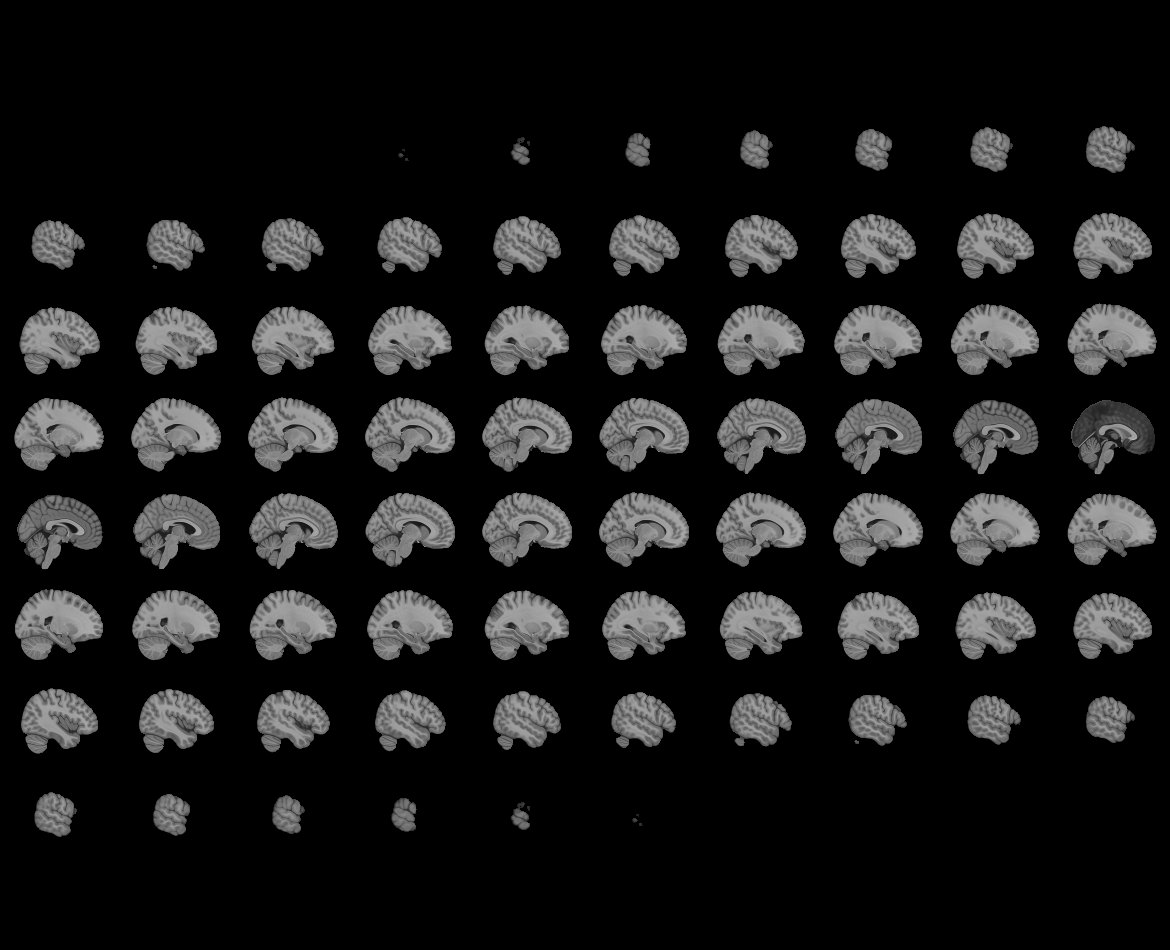
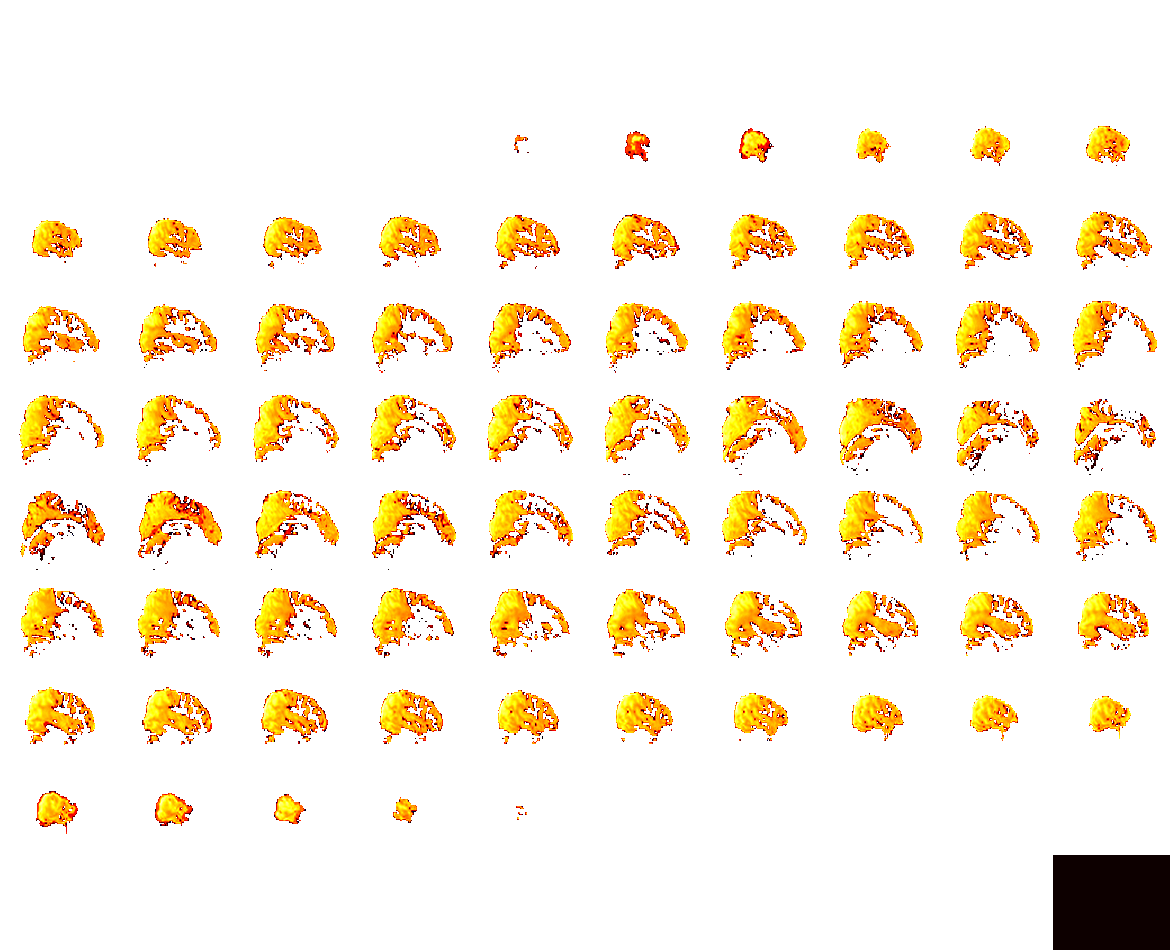

In [13]:
# Take a look at the average for the masked image
plotting.view_img(image.mean_img(thresholded_img_1))

/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


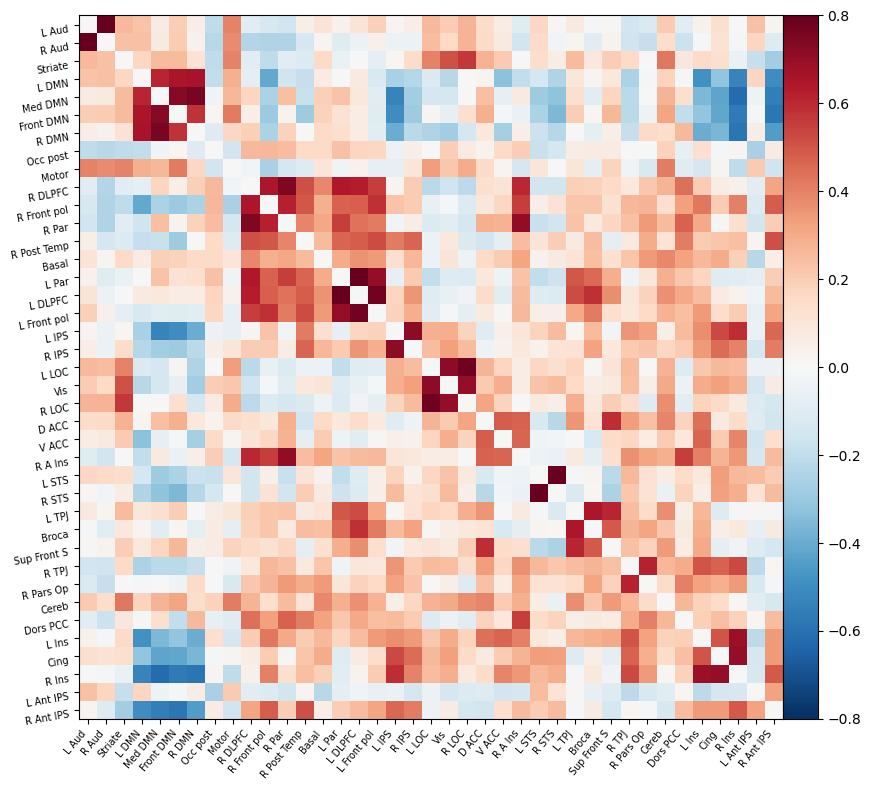

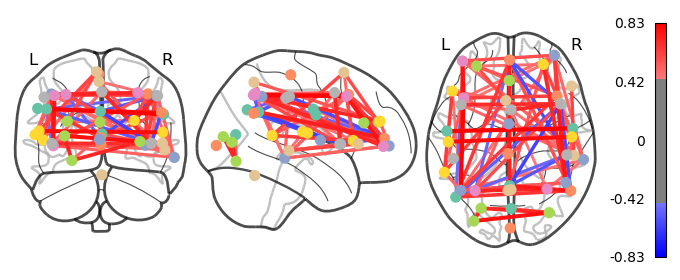

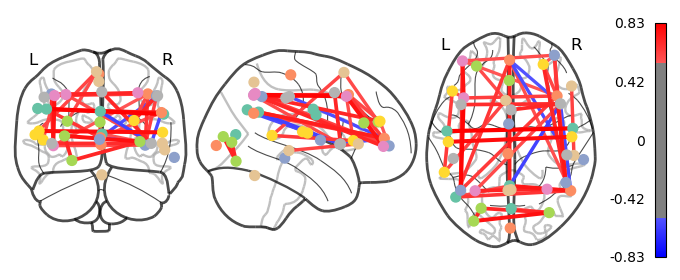

In [14]:
correlation_matrix_1 = show_results(atlas_filepath, labels, fmri_filepath_1, confounds_1)

## Session 2: Sleep deprived

In [15]:
fmri_filepath_2, mask_filepath_2, fmri_img_2 = load_img(ses_id=2)

session id: 2
sleep: deprived
<class 'nibabel.nifti1.Nifti1Image'>
data shape (87, 103, 65, 196)
affine: 
[[   2.25    0.      0.    -96.5 ]
 [   0.      2.25    0.   -132.5 ]
 [   0.      0.      3.    -78.5 ]
 [   0.      0.      0.      1.  ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  87 103  65 196   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   2.25 2.25 3.   2.5  1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 8450.272
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descr

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



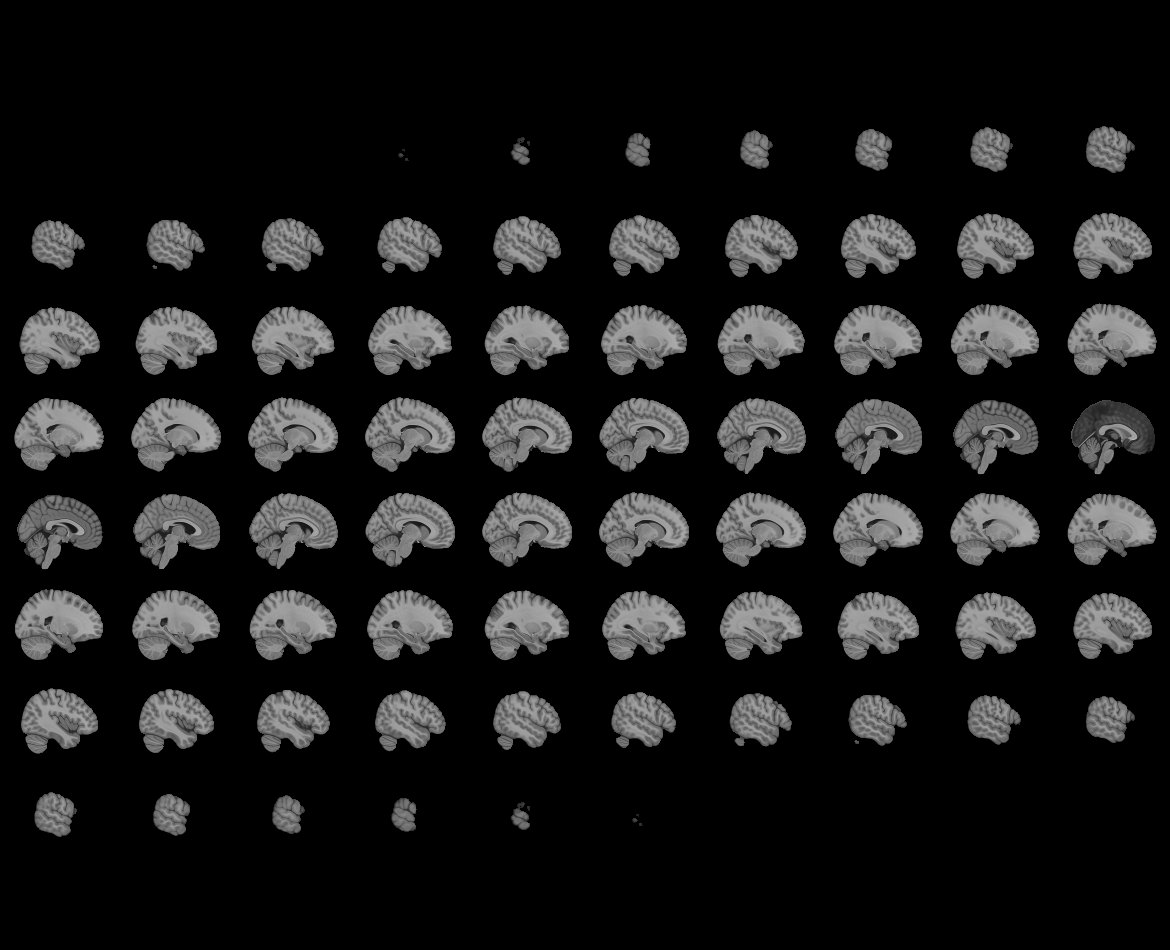
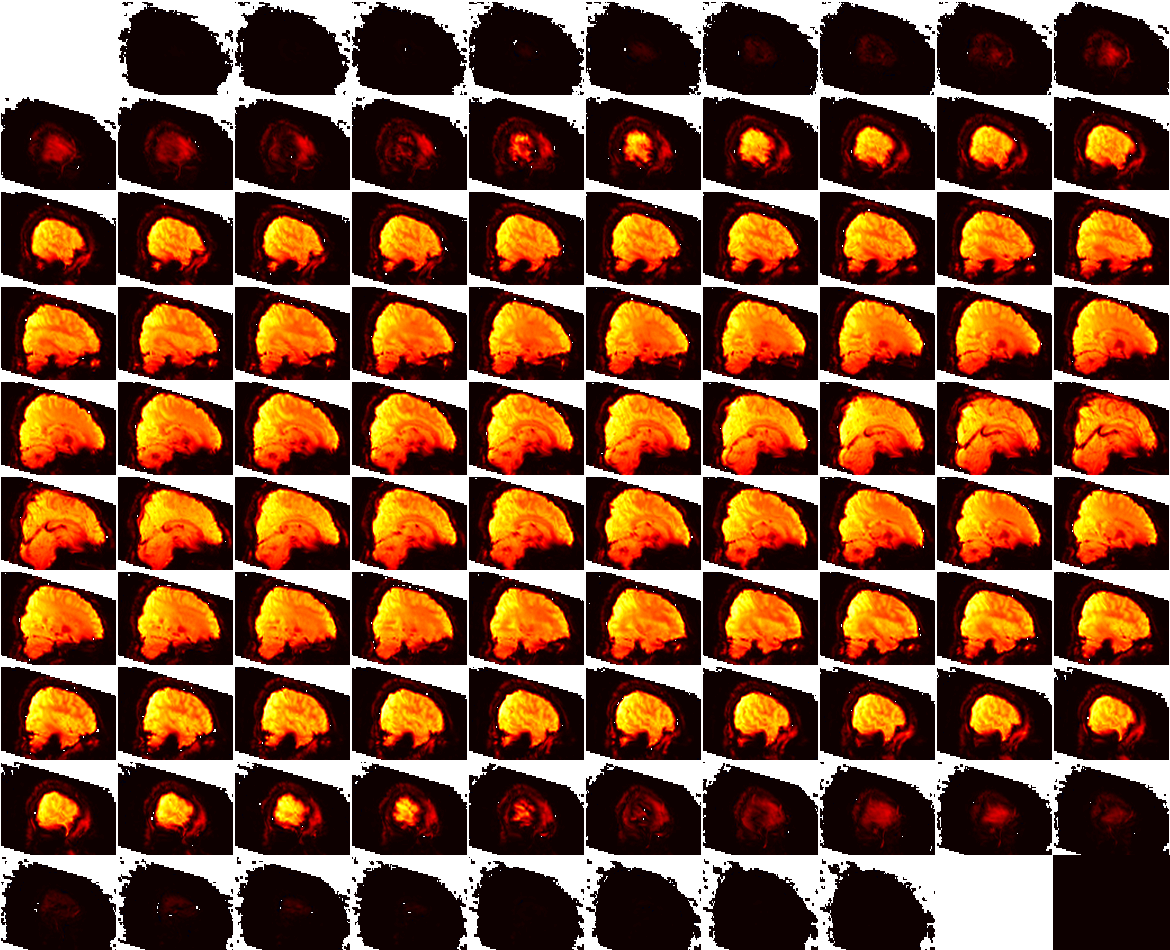

In [16]:
# Take a look at the average
plotting.view_img(image.mean_img(fmri_img_2))

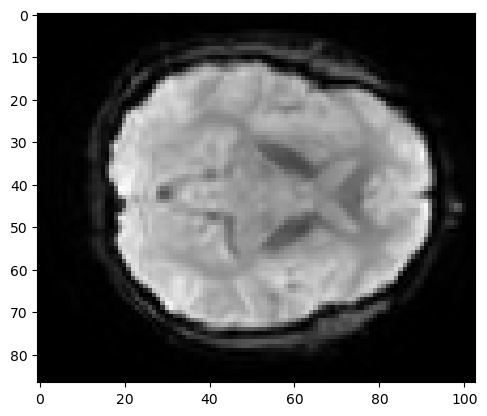

In [17]:
# let's get the data array 
fmri_data_2 = fmri_img_2.get_fdata()
# Plot a (trasnversal) slice of the brain for a time point as an image
plt.imshow(fmri_data_2[:,:,25,0], cmap='gray')

Number of voxels
Before masking: 582465
After masking: (196, 119359)


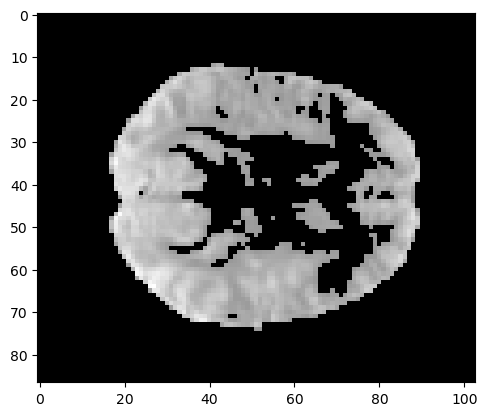

In [18]:
confounds_2, thresholded_img_2 = mask_data(2, fmri_data_2, fmri_filepath_2, mask_filepath_2)

In [19]:
confounds_2.head()

cosine00  cosine01  cosine02  cosine03  cosine04  cosine05        csf  \
0  0.101012  0.101002  0.100986  0.100963  0.100934  0.100898  19.547559   
1  0.100986  0.100898  0.100753  0.100548  0.100286  0.099966  12.445030   
2  0.100934  0.100691  0.100286  0.099720  0.098995  0.098110  13.214544   
3  0.100856  0.100380  0.099588  0.098483  0.097067  0.095347  12.683641   
4  0.100753  0.099966  0.098660  0.096840  0.094517  0.091702   0.105300   

      rot_x  rot_x_derivative1  rot_x_derivative1_power2  ...  trans_x_power2  \
0 -0.000795           0.000500             -2.136857e-09  ...       -0.003932   
1 -0.000278           0.000500             -2.136857e-09  ...       -0.003903   
2 -0.000113           0.000148             -2.421963e-07  ...       -0.003881   
3 -0.000479          -0.000383             -1.352939e-07  ...       -0.004045   
4 -0.000113           0.000350             -1.352939e-07  ...       -0.004142   

    trans_y  trans_y_derivative1  trans_y_derivative1_power2  trans_y_power2  \
0 -0.040263             0.015448                    0.000012       -0.003519   
1 -0.024128             0.015448                    0.000012       -0.003067   
2 -0.016792             0.006650                   -0.000194       -0.002690   
3 -0.038824            -0.022717                    0.000238       -0.003500   
4 -0.031428             0.006710                   -0.000193       -0.003336   

    trans_z  trans_z_derivative1  trans_z_derivative1_power2  trans_z_power2  \
0 -0.156384            -0.010537                   -0.001392       -0.037872   
1 -0.165799            -0.010537                   -0.001392       -0.037013   
2 -0.168422            -0.003745                   -0.001474       -0.036742   
3 -0.155321             0.011979                   -0.001309       -0.037958   
4 -0.136493             0.017705                   -0.001126       -0.039103   

   white_matter  
0     11.924944  
1     13.679839  
2      6.856638  
3      4.969661  
4      0.057561  

[5 rows x 32 columns]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



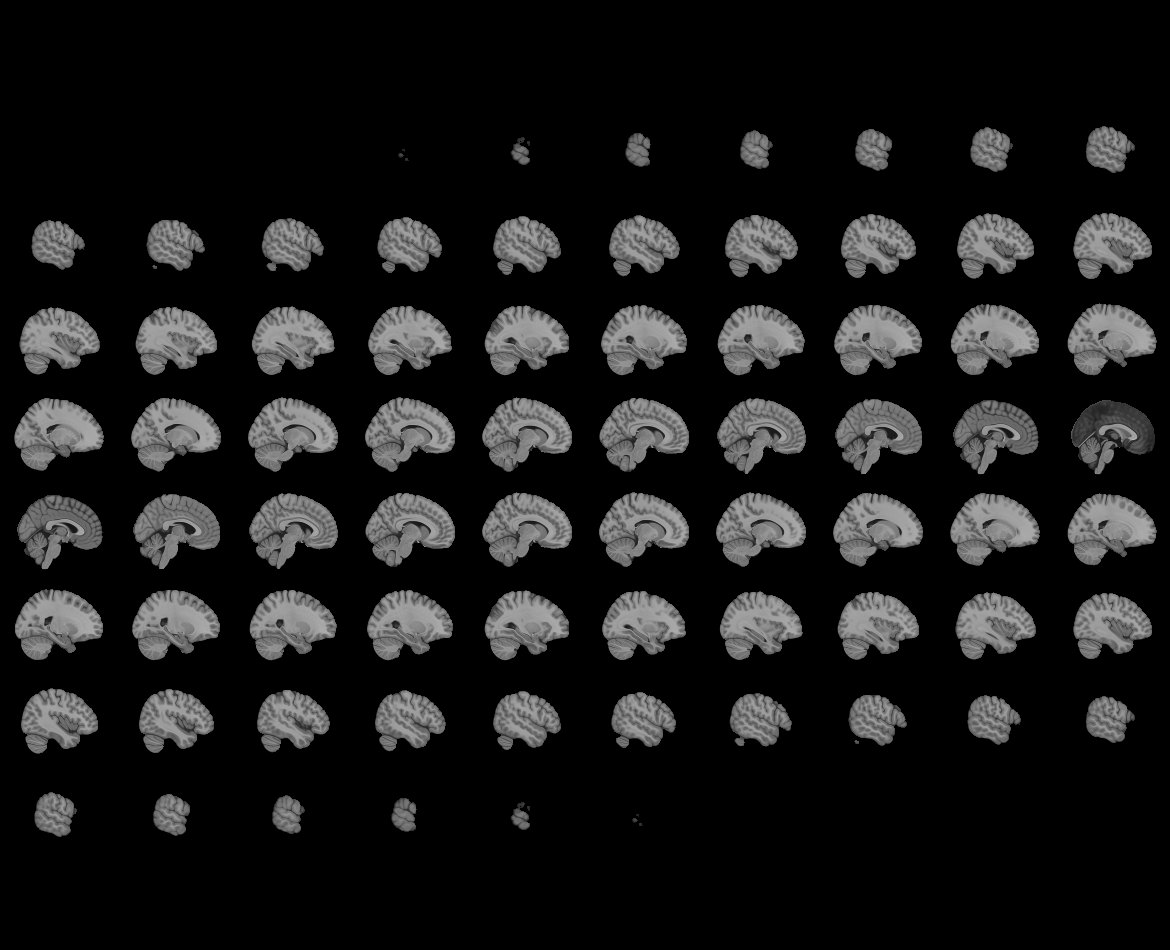
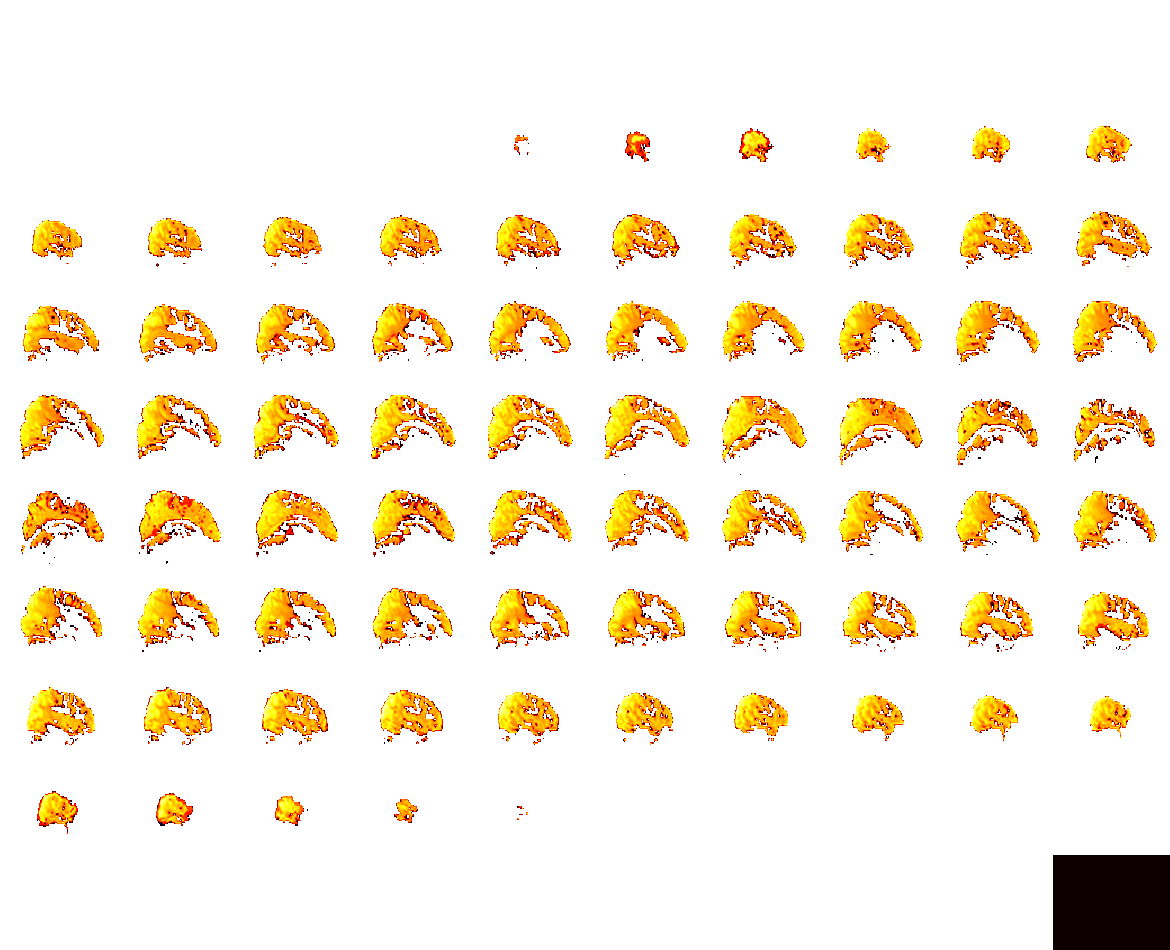

In [20]:
# Take a look at the average for the masked image
plotting.view_img(image.mean_img(thresholded_img_2))

/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


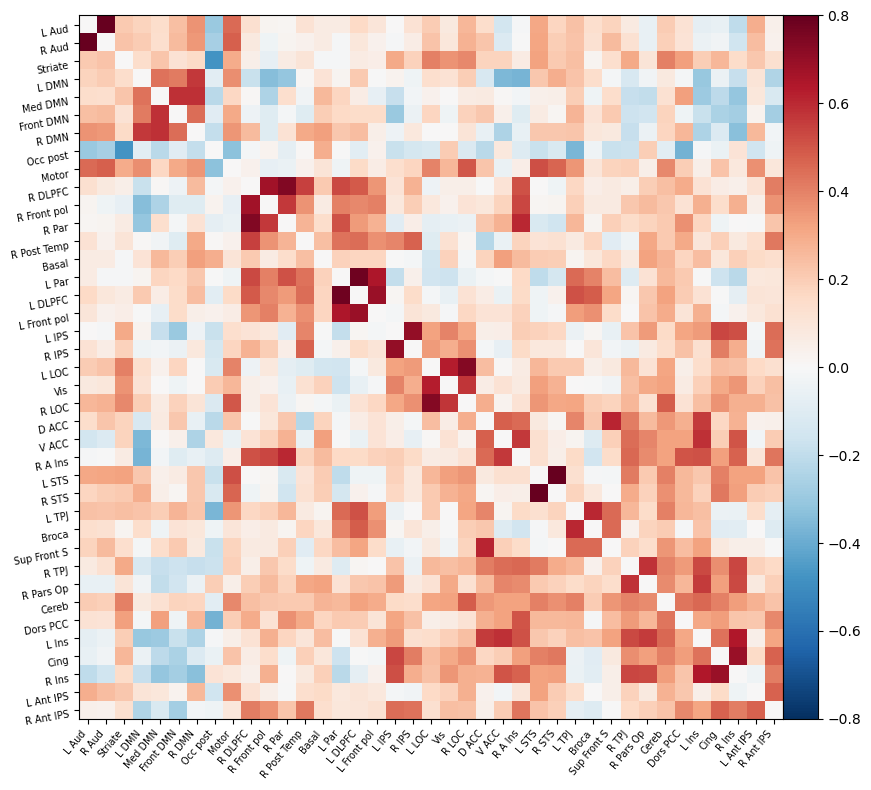

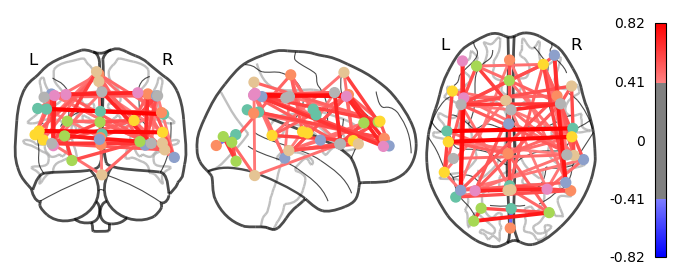

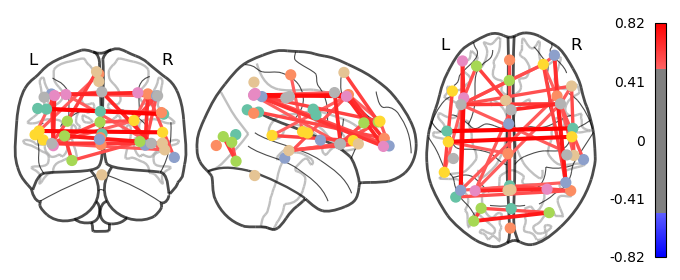

In [21]:
correlation_matrix_2 = show_results(atlas_filepath, labels, fmri_filepath_2, confounds_2)

## Analyze the difference

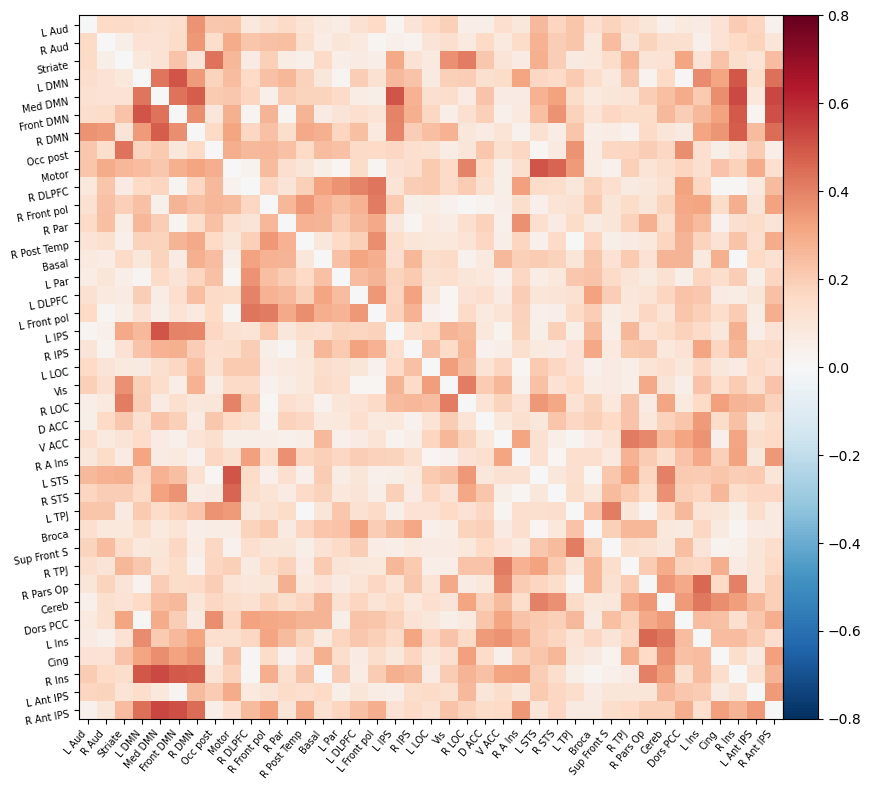

In [22]:
correlation_matrix_diff = np.sqrt(np.abs(correlation_matrix_1**2 - correlation_matrix_2**2))
plotting.plot_matrix(correlation_matrix_diff, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8)